In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Load the dataset
file_path = 'data/monatszahlen2405_verkehrsunfaelle_export_31_05_24_r.csv'
data = pd.read_csv(file_path)

In [25]:
# Filter for the relevant category and type
filtered_data = data[
    (data['MONATSZAHL'] == 'Alkoholunfälle') &
    (data['AUSPRAEGUNG'] == 'insgesamt') &
    (data['JAHR'] <= 2020)
]
filtered_data = filtered_data[['JAHR', 'MONAT', 'WERT']].dropna()

# Remove summary rows and convert month to datetime
filtered_data = filtered_data[filtered_data['MONAT'] != 'Summe']
filtered_data['MONTH'] = pd.to_datetime(filtered_data['JAHR'].astype(str) + filtered_data['MONAT'].str[-2:], format='%Y%m')
filtered_data = filtered_data[['MONTH', 'WERT']].set_index('MONTH').sort_index()

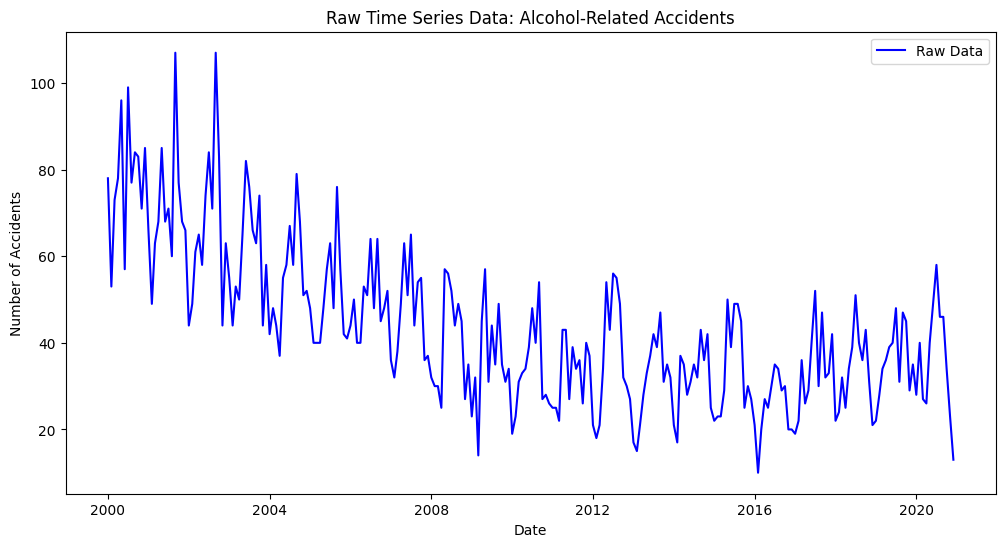

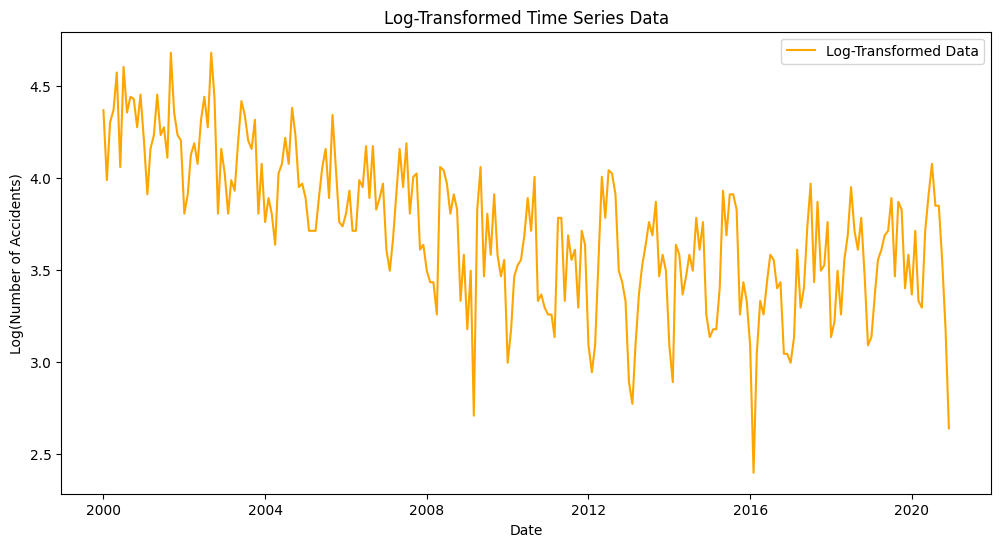

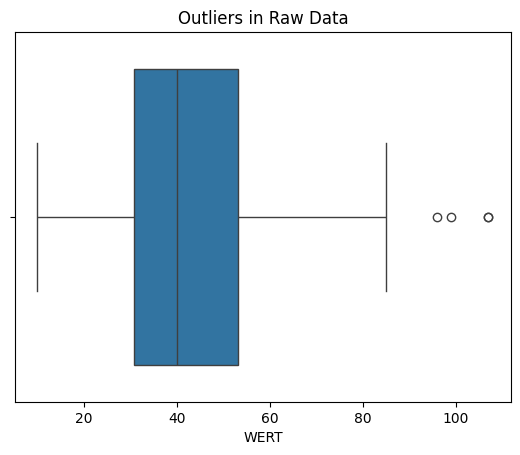

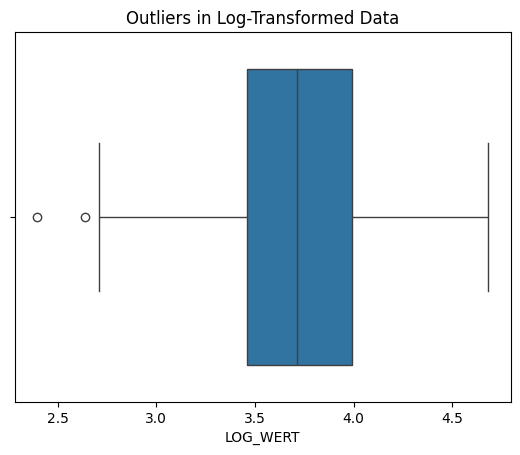

In [26]:
# EDA: Plot raw data
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['WERT'], label='Raw Data', color='blue')
plt.title("Raw Time Series Data: Alcohol-Related Accidents")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.legend()
plt.show()

# Apply log transformation
filtered_data['LOG_WERT'] = np.log1p(filtered_data['WERT'])
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['LOG_WERT'], label='Log-Transformed Data', color='orange')
plt.title("Log-Transformed Time Series Data")
plt.xlabel("Date")
plt.ylabel("Log(Number of Accidents)")
plt.legend()
plt.show()

# Visualize outliers
sns.boxplot(x=filtered_data['WERT'])
plt.title("Outliers in Raw Data")
plt.show()

sns.boxplot(x=filtered_data['LOG_WERT'])
plt.title("Outliers in Log-Transformed Data")
plt.show()

In [27]:
# Prepare for comparison
results = []

# ARIMA on raw data
model_raw = ARIMA(filtered_data['WERT'], order=(1, 1, 1))
fitted_model_raw = model_raw.fit()
forecast_raw = fitted_model_raw.get_forecast(steps=1)
forecast_value_raw = forecast_raw.predicted_mean.iloc[0]
results.append({"Model": "ARIMA (Raw)", "Forecast": forecast_value_raw})

# ARIMA on log-transformed data
model_log = ARIMA(filtered_data['LOG_WERT'], order=(1, 1, 1))
fitted_model_log = model_log.fit()
forecast_log = fitted_model_log.get_forecast(steps=1)
forecast_value_log = np.expm1(forecast_log.predicted_mean.iloc[0])  # Reverse log transformation
results.append({"Model": "ARIMA (Log)", "Forecast": forecast_value_log})

# Auto-ARIMA on raw data
auto_arima_raw = auto_arima(
    filtered_data['WERT'], 
    seasonal=False, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)
forecast_auto_raw = auto_arima_raw.predict(n_periods=1)[0]
results.append({"Model": "Auto-ARIMA (Raw)", "Forecast": forecast_auto_raw})

# Auto-ARIMA on log-transformed data
auto_arima_log = auto_arima(
    filtered_data['LOG_WERT'], 
    seasonal=False, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)
forecast_auto_log = np.expm1(auto_arima_log.predict(n_periods=1)[0])  # Reverse log transformation
results.append({"Model": "Auto-ARIMA (Log)", "Forecast": forecast_auto_log})

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1927.066, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1997.543, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1959.851, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1956.164, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1995.645, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1960.127, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1925.567, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1927.558, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1958.829, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1925.646, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1960.820, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1929.547, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1927.933, Time=0.03 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 0.479 seconds
Performing stepwise se

/var/folders/6l/rd9mz6093d1688p05vb4jvk80000gn/T/ipykernel_62370/3152951319.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_auto_raw = auto_arima_raw.predict(n_periods=1)[0]


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=39.833, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=53.271, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38.334, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39.601, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73.916, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.599, Time=0.02 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.446 seconds


/var/folders/6l/rd9mz6093d1688p05vb4jvk80000gn/T/ipykernel_62370/3152951319.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_auto_log = np.expm1(auto_arima_log.predict(n_periods=1)[0])  # Reverse log transformation


              Model   Forecast  Ground Truth  Absolute Error  Percentage Error
0       ARIMA (Raw)  25.622543          16.0        9.622543         60.140892
1       ARIMA (Log)  20.472689          16.0        4.472689         27.954303
2  Auto-ARIMA (Raw)  22.959208          16.0        6.959208         43.495051
3  Auto-ARIMA (Log)  19.571858          16.0        3.571858         22.324113


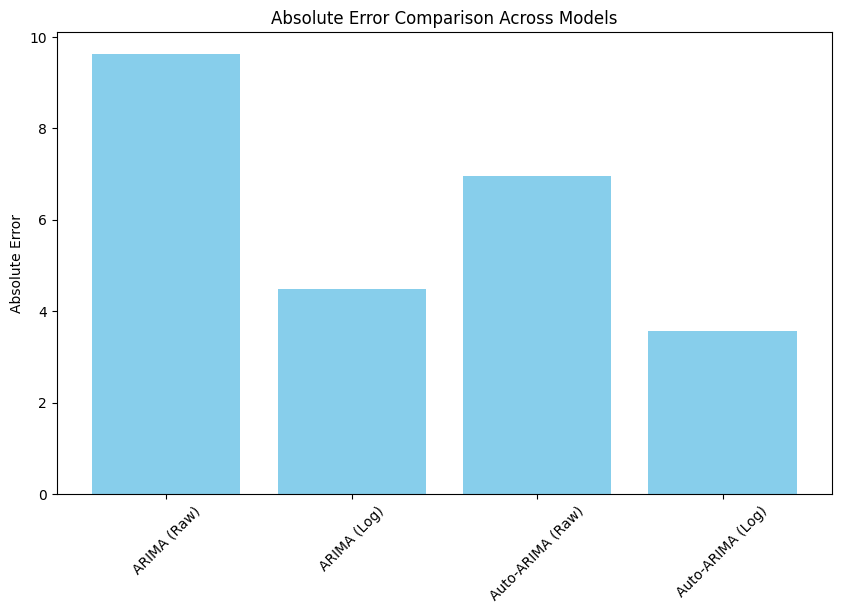

In [28]:
# Ground Truth
ground_truth = data[
    (data['MONATSZAHL'] == 'Alkoholunfälle') &
    (data['AUSPRAEGUNG'] == 'insgesamt') &
    (data['JAHR'] == 2021) &
    (data['MONAT'] == '202101')
]['WERT'].values

if len(ground_truth) > 0:
    ground_truth_value = ground_truth[0]
    for result in results:
        result["Ground Truth"] = ground_truth_value
        result["Absolute Error"] = abs(ground_truth_value - result["Forecast"])
        result["Percentage Error"] = (result["Absolute Error"] / ground_truth_value) * 100
else:
    for result in results:
        result["Ground Truth"] = None
        result["Absolute Error"] = None
        result["Percentage Error"] = None

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Absolute Error'], color='skyblue')
plt.title('Absolute Error Comparison Across Models')
plt.ylabel('Absolute Error')
plt.xticks(rotation=45)
plt.show()

Auto-ARIMA model is performing 2x better than ARIMA model. However there is room for improvement. Maybe we should consider trying other models or techniques:
- Prophet
- SARIMA
- Seasonality Analysis
- SARIMA